In [1]:
import numpy as np 
import pandas as pd

import re
import string
from itertools import islice

import nltk
from nltk.corpus import twitter_samples

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer

import missingno as msnum

import operator

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
#gaining some insight on data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
#cheching if there is nulls, we already know there is nulls from df.info() but this is easier to read

df.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [5]:
#number of nulls for each column

df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
#percentage of nulls for each column

round((((df.isnull().sum())/len(df.index))*100),2)

id           0.00
keyword      0.80
location    33.27
text         0.00
target       0.00
dtype: float64

<AxesSubplot:>

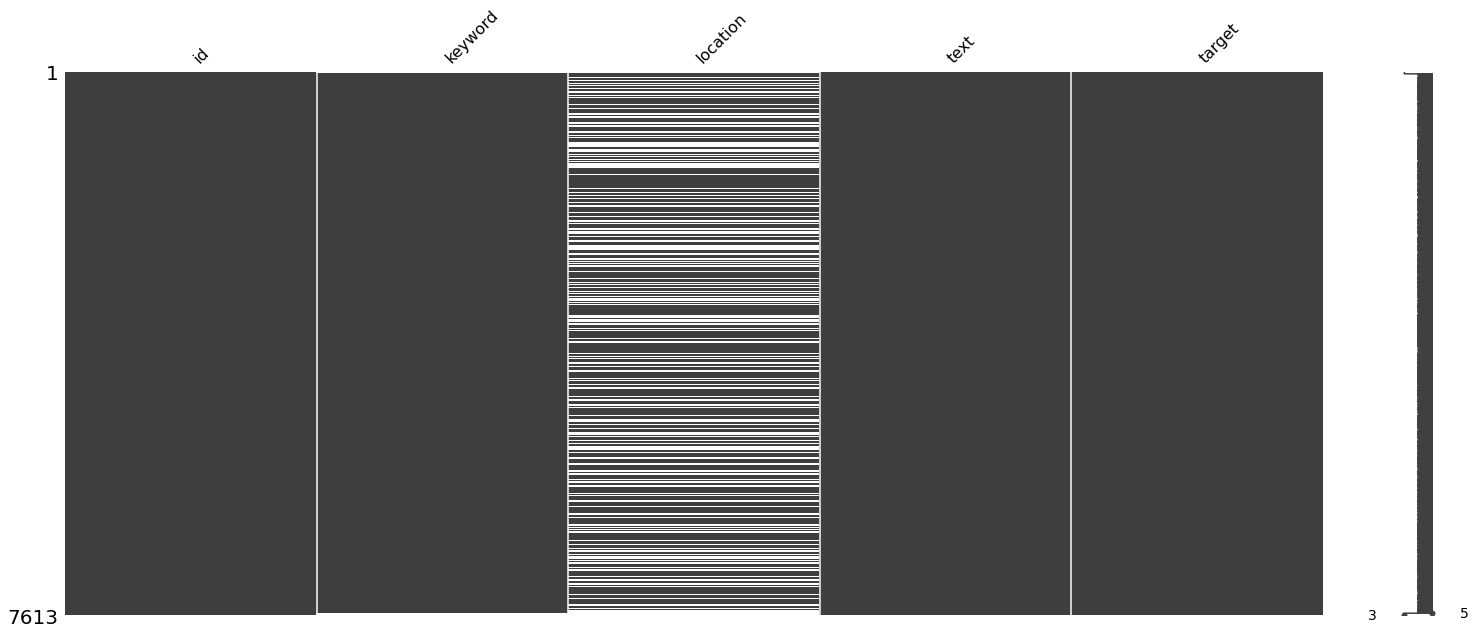

In [7]:
#visualizing nulls

msnum.matrix(df)

In [8]:
#top 15 locations

n = 15
lcs = df['location'].value_counts().index.tolist()[:n]
lcsCount = df['location'].value_counts().values.tolist()[:n]

TopLocations = pd.DataFrame(list(zip(lcs, lcsCount)), columns =['Location', 'Count'])
TopLocations

,Location,Count
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29
5,Nigeria,28
6,UK,27
7,"Los Angeles, CA",26
8,India,24
9,Mumbai,22


In [9]:
#top 15 keywords

n = 15
kw = df['keyword'].value_counts().index.tolist()[:n]
kwCount = df['keyword'].value_counts().values.tolist()[:n]

TopKeywords = pd.DataFrame(list(zip(kw, kwCount)), columns =['keyword', 'Count'])
TopKeywords

,keyword,Count
0,fatalities,45
1,deluge,42
2,armageddon,42
3,damage,41
4,sinking,41
5,harm,41
6,body%20bags,41
7,fear,40
8,windstorm,40
9,siren,40


In [10]:
#tweet cleaning function

def cleanText(text):
    text=re.sub(r'(@|#)[a-zA-Z0-9_]+','',text) # remove hashtags and usernames
    text=re.sub(r'https?:\/\/\S+',' ',text) #removing hyperlinks
    text=re.sub(r'\W',' ',text) #removing special characters
    text=re.sub(r'\d','',text) #removing special characters
    text=re.sub(r'(^\s+)','',text)  #removing space in front text 
    text=re.sub(r'(\s+$)','',text) #removing space in tail text 
    text=re.sub(r'\s[0-9]+\s','',text) #removing numbers
    text=text.lower() #making all text in lowercase
    return text

In [11]:
#most common words before stemming and removing stop words

wordsCount = {}
for tweet in df['text']:
    newTweet = cleanText(tweet).split()
    
    for word in newTweet:
        
        if word in stop_words:
            continue
        
        if word in wordsCount:
            wordsCount[word] += 1
        
        else:
            wordsCount[word] = 1

            
#sorting the dictionary

N = 10
wordsCount = dict(sorted(wordsCount.items(), key=operator.itemgetter(1), reverse=True)[:N])
pd.DataFrame([wordsCount])

,like,û_,amp,fire,get,new,via,people,one,video
0,348,344,344,250,229,226,220,198,196,161


In [12]:
#most common stop words before stemming

stopWordsCount = {}
for tweet in df['text']:
    newTweet = cleanText(tweet).split()
    
    for word in newTweet:
        
        if word not in stop_words:
            continue
            
        if word in stopWordsCount:
            stopWordsCount[word] += 1
            
        else:
            stopWordsCount[word] = 1

            
#sorting the dictionary

N = 10
stopWordsCount = dict(sorted(stopWordsCount.items(), key=operator.itemgetter(1), reverse=True)[:N])
pd.DataFrame([stopWordsCount])

,the,a,in,to,of,i,and,is,s,you
0,3276,2217,1985,1949,1830,1791,1426,949,924,902


In [13]:
#tweets processing function

def ProcessTweets(tweets):
    cleanTweets=[]
    for tweet in tweets:
        
        #cleaning tweets
        tweet=cleanText(tweet)
        
        #tokenization
        tweet=tweet.split()
        
        #removing Stopwords
        tweet=[token for token in tweet if len(token) > 2  and token not in stop_words]
        
        #stemming
        ps = PorterStemmer()
        tweet=[ps.stem(word) for word in  tweet]
        
        cleanTweets.append(tweet)
        
    return cleanTweets

In [14]:
#processing all tweets in the dataset

df['text'] = ProcessTweets(df['text'])

In [15]:
#most common words after processing tweets

wordsCount = {}
for tweet in df['text']:
    for word in tweet:
        
        if word in wordsCount:
            wordsCount[word] += 1
        
        else:
            wordsCount[word] = 1

            
#sorting the dictionary

N = 10
wordsCount = dict(sorted(wordsCount.items(), key=operator.itemgetter(1), reverse=True)[:N])
pd.DataFrame([wordsCount])

,like,fire,amp,get,bomb,new,via,one,peopl,time
0,410,358,344,311,237,226,220,206,199,181


In [16]:
#splitting positvie and negative tweets (indicates disaster = positive (1) , does not indicate disaster = negative (0))

positiveTweets = []
negativeTweets = []

for i in range(len(df['target'])):
    
    if df['target'][i] == 1:
        positiveTweets.append(df['text'][i])
    
    elif df['target'][i] == 0:
        negativeTweets.append(df['text'][i])
               
print(len(positiveTweets))
print(len(negativeTweets))

3271
4342


In [17]:
tweets = []
labels = []
for i in range(len(positiveTweets)):
    if i < len(negativeTweets):
        tweets.append(positiveTweets[i])
        tweets.append(negativeTweets[i])
        labels.append(1)
        labels.append(0)
    else:
        tweets.append(positiveTweets[i])
        labels.append(1)

In [18]:
#word frequencies builder function

def BuildFrequencies(tweets,labels):
    freq={}
    
    for i in range(len(tweets)):
        
        for word in tweets[i]:
            key=word
            
            if key not in freq.keys():
                
                if labels[i]==1:
                    freq[key]=[1,0]
                else:
                    freq[key]=[0,1]
                    
            else:
                if labels[i]==1:
                    freq[key][0]+=1
                else:
                    freq[key][1]+=1

    return freq

freqDict=BuildFrequencies(tweets,labels)

#checking newly created frequency dicts
print(dict(islice(freqDict.items(), 0, 4)))

{'deed': [1, 1], 'reason': [8, 18], 'may': [50, 29], 'allah': [4, 0]}


In [19]:
#Building Features function

def buildFeatures(tweets,freqs):
    features=[]
    
    for tweet in tweets:
        X=[1,0,0]
        for word in tweet:
            
            #checking if word in frequencies dictionary to prevent errors when testing
            if word in freqs:
                X[1]+=freqs.get(word,0)[0]
                X[2]+=freqs.get(word,0)[1]
            else:
                continue
                              
        features.append(X)

    return features

In [20]:
#building the features and checking its shape

features=buildFeatures(tweets,freqDict)
X=np.array(features)
X.shape

(6542, 3)

In [21]:
#splitting data into train and test sets

train_X,test_X,train_y,test_y=train_test_split(X,np.array(labels),test_size=0.2)

# Choosing the ML Model

In [22]:
#creating models

models = [['LogisticRegression : ', LogisticRegression()],
          ['KNN : ', KNeighborsClassifier()],
          ['SVM : ', SVC()],
          ['DecisionTree : ', DecisionTreeClassifier(random_state=0)],
          ['RandomForest : ', RandomForestClassifier(random_state=0)],
          ['XGBoost : ', XGBClassifier()],
          ['NaiveBayes : ', GaussianNB()]]

In [23]:
#fitting and testing models using predit

for name, model in models:
    model.fit(train_X, train_y)
    
    y_pred = model.predict(test_X)
    y_pred_train = model.predict(train_X)
    
    print(name)
    print("Training: ", round(f1_score(train_y, y_pred_train),2)*100, '%')
    print("Testing: ")
    print('    accuarcy: ',round(accuracy_score(test_y,y_pred),2)*100, '%')
    print('    F1 score: ',round(f1_score(test_y,y_pred),2)*100, '%')
    print("=============================")

LogisticRegression : 
Training:  77.0 %
Testing: 
    accuarcy:  80.0 %
    F1 score:  80.0 %
KNN : 
Training:  83.0 %
Testing: 
    accuarcy:  78.0 %
    F1 score:  78.0 %
SVM : 
Training:  78.0 %
Testing: 
    accuarcy:  81.0 %
    F1 score:  80.0 %
DecisionTree : 
Training:  98.0 %
Testing: 
    accuarcy:  72.0 %
    F1 score:  73.0 %
RandomForest : 
Training:  98.0 %
Testing: 
    accuarcy:  78.0 %
    F1 score:  78.0 %


C:\Users\Moham\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost : 
Training:  86.0 %
Testing: 
    accuarcy:  78.0 %
    F1 score:  78.0 %
NaiveBayes : 
Training:  61.0 %
Testing: 
    accuarcy:  70.0 %
    F1 score:  63.0 %


# Applying Grid Search on Random Forest Classifier

In [24]:
rf_model = RandomForestClassifier(random_state=0)
parameters = {
            'n_estimators' : [100, 150, 200],
            'max_depth' : [7, 9, 11],
            'max_features' : [0.5, 0.7, 0.9],
            'min_samples_split' : [2, 4, 6]
}
scorer = make_scorer(f1_score)
clf = GridSearchCV(estimator=rf_model, param_grid=parameters, scoring=scorer)
grid_fit = clf.fit(train_X, train_y)
best_clf = grid_fit.best_estimator_
print(best_clf)

y_pred = best_clf.predict(test_X)
y_pred_train = best_clf.predict(train_X)
    
print(name)
print("Training: ", round(f1_score(train_y, y_pred_train),2)*100, '%')
print("Testing: ")
print('    accuarcy: ',round(accuracy_score(test_y,y_pred),2)*100, '%')
print('    F1 score: ',round(f1_score(test_y,y_pred),2)*100, '%')
print("=============================")

RandomForestClassifier(max_depth=7, max_features=0.7, min_samples_split=6,
                       random_state=0)
NaiveBayes : 
Training:  80.0 %
Testing: 
    accuarcy:  81.0 %
    F1 score:  80.0 %


# Applying Ensemble Learning on Random Forest Classifier

In [25]:
#bagging

bag_RF = BaggingClassifier(base_estimator=best_clf, n_estimators=20, random_state=0,
                           max_samples=0.3, max_features=0.5)

bag_RF.fit(train_X, train_y)
y_pred_bag_RF_train = bag_RF.predict(train_X)
y_pred_bag_RF_test = bag_RF.predict(test_X)

print("Training: ", round(f1_score(train_y,y_pred_bag_RF_train),2)*100, '%')
print("Testing: ")
print('    accuarcy: ',round(accuracy_score(test_y,y_pred_bag_RF_test),2)*100, '%')
print('    F1 score: ',round(f1_score(test_y,y_pred_bag_RF_test),2)*100, '%')

Training:  74.0 %
Testing: 
    accuarcy:  73.0 %
    F1 score:  72.0 %


In [26]:
#boosting

boost_RF = AdaBoostClassifier(base_estimator=best_clf, n_estimators=20, random_state=0)

boost_RF.fit(train_X, train_y)
y_pred_boost_RF_train = boost_RF.predict(train_X)
y_pred_boost_RF_test = boost_RF.predict(test_X)

print("Training: ", round(f1_score(train_y, y_pred_boost_RF_train),2)*100, '%')
print("Testing: ")
print('    accuarcy: ',round(accuracy_score(test_y,y_pred_boost_RF_test),2)*100, '%')
print('    F1 score: ',round(f1_score(test_y,y_pred_boost_RF_test),2)*100, '%')

Training:  91.0 %
Testing: 
    accuarcy:  78.0 %
    F1 score:  78.0 %


## best model is Random Forest without bagging or boosting, and it can further improved with hyperparameter tuning

# Testing Model

In [27]:
#reading test set

dfTest=pd.read_csv('test.csv')

In [28]:
#processing test tweets

dfTest['text']=ProcessTweets(dfTest['text'])

In [29]:
#copying the tweets into a new list

tweetsTest = []
for i in range(len(dfTest['text'])):
    tweetsTest.append(dfTest['text'][i])

In [30]:
# Testing Model

testFeatures = buildFeatures(tweetsTest,freqDict)
prediction = best_clf.predict(testFeatures)
prediction

array([1, 0, 1, ..., 1, 1, 0])